In [7]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader,Dataset
from collections import defaultdict


DAYS_FOR_TRAIN = 3
FEATURE_SIZE = 10
BATCH_SIZE = 32
TEST_SIZE = 0.1
DROPOUT_PROB = 0
OUTPUT_SIZE = 3

with_sent = True

# selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30]
if with_sent:
    selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30] # with sent
else:
    selected_ft = [1, 2, 3, 4, 5, 57, 26, 42, 19, 32, 33, 25, 15, 17, 14, 24, 67, 88, 43, 58, 18, 60, 36, 66, 28] 
    
selected_ft = selected_ft[:FEATURE_SIZE]



In [8]:
def my_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(extend_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


class StockDataset(Dataset):
    """stock market dataset"""
    
    def __init__(self, dataset, days_for_train=5, feature_size=5, scaled=True, scaler=None):
        self.days_for_train = days_for_train
        self.feature_size = feature_size
        self.ori_data = dataset

        self.data = self.ori_data.iloc[:, selected_ft].values.astype(np.float32)
#         print(self.data)
        if scaled:
            if scaler is None:
                self.scaler = MinMaxScaler()
                self.data = self.scaler.fit_transform(self.data).astype(np.float32)
            else:
                self.data = scaler.transform(self.data).astype(np.float32)
                self.scaler = scaler
        
        self.x = self.data
        self.y = self.data[:, 3]
        
        

    def __len__(self):
        return self.data.shape[0] - self.days_for_train - OUTPUT_SIZE + 1

    
    def __getitem__(self, idx):
        x = self.x[idx:idx+self.days_for_train]
#         y = np.zeros((1), dtype=np.float32)

        y = np.asarray(self.y[idx+self.days_for_train: idx+self.days_for_train + OUTPUT_SIZE], dtype=np.float32)

        t_x = torch.from_numpy(x)
        t_y = torch.from_numpy(y)
        return t_x, t_y
    
    def get_scaler(self):
        return self.scaler


class BaseLSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)

    def forward(self, _x):
        out0 = self.fc0(_x)
        x, _ = self.lstm(out0)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        out1 = self.fc(x)
        out1 = out1.view(s, b)  # 把形状改回来
        out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
        out2 = self.fc2(out1)
        # print(out2.shape)
        # out2 = out2.view(b, -1)
        return out2
    

class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=3, num_layers=2):
        super().__init__()

#         self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)
#         self.out_fc = nn.Linear()

        self.dropout = nn.Dropout(DROPOUT_PROB)

        
    def attention_net(self, x, query, mask=None):
        d_k = query.size(-1)
        
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)
        
        alpha_n = F.softmax(scores, dim=-1)
        
        context = torch.matmul(alpha_n, x).sum(1)
        
        return context, alpha_n
        
        
    def forward(self, _x):
#         out0 = self.fc0(_x)
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
#         print(x.shape)
        x = x.permute(1, 0, 2)
#         print(x.shape)
        query = self.dropout(x)
        x, _ = self.attention_net(x, query)
    
#         print(x.shape)
#         s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        
        
#         x = x.view(s*b, h)
        out1 = self.fc(x)
#         out1 = out1.view(s, b)  # 把形状改回来
#         out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
#         out2 = self.fc2(out1)
        # print(out2.shape)
        return out1
    

def my_train(train_dataset):
#     print(train_dataset)
    data = StockDataset(train_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE)
    D = DataLoader(dataset=data, batch_size=BATCH_SIZE)

    model = LSTM_Regression(FEATURE_SIZE, 8, output_size=OUTPUT_SIZE, num_layers=2)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(700):       
        for i, (x, y) in enumerate(D):
#             print(x.shape, y.shape)
            x = x.transpose(0, 1)
#             x.transpose(1, 2)
            pred_y = model(x)
#             print('pred_y: ', pred_y.shape)
            loss = loss_function(pred_y, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # out = model(train_x)
        # loss = loss_function(out, train_y)

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

        if (epoch+1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))
    
    return model, data.scaler


In [9]:
def my_test(model, test_dataset, train_scaler, output_file):
    model.eval()
    loss_function = nn.MSELoss()

    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
    test_D = DataLoader(dataset=test_data, batch_size=1)

    preds = defaultdict(list)
    targets = defaultdict(list)
    
    ori_preds = defaultdict(list)
    ori_targets = defaultdict(list)
    
    def rev_scale(x):
        return (x - train_scaler.min_[3]) / train_scaler.scale_[3]

    for i, (test_x, test_y) in enumerate(test_D):
        test_x = test_x.transpose(0, 1)
#         test_x = test_x.to(device)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
#         pred_y = pred_y.cpu()
#         print(pred_y)

        
        tmp_pred_y = pred_y.detach().numpy()[0]
        tmp_test_y = test_y.detach().numpy()[0]
        
        for i in range(3):
            
            preds[str(i)].append(tmp_pred_y[i])
            targets[str(i)].append(tmp_test_y[i])

            ori_pred_y = (tmp_pred_y[i] - train_scaler.min_[3]) / train_scaler.scale_[3]
            ori_test_y = (tmp_test_y[i] - train_scaler.min_[3]) / train_scaler.scale_[3]


            ori_preds[str(i)].append(ori_pred_y)
            ori_targets[str(i)].append(ori_test_y)

#         rmse = loss_function(test_y, pred_y)
#         all_rmse.append(rmse)
        
#         mae = mean_absolute_error(tmp_test_y, tmp_pred_y)
#         all_mae.append(mae)
    
#         print(test_loss)

    for i in range(3):
        print('%d day mse: %.5f' % (i+1, mean_squared_error(targets[str(i)], preds[str(i)])))
        print('%d day ori mse: %.5f' % (i+1, mean_squared_error(ori_targets[str(i)], ori_preds[str(i)])))

        print('%d day ori mae: %.5f' % (i+1, mean_absolute_error(ori_targets[str(i)], ori_preds[str(i)])))
    
#     print('test rmse: %.5f' % (sum(all_rmse)))
#     print('test mae: %.5f' % (sum(all_mae)))
    
    train_size = len(test_data) * (1 - TEST_SIZE)
    plt.plot(preds['0'], 'r', label='prediction')
    plt.plot(targets['0'], 'b', label='real')
    plt.grid()
    plt.legend()
    plt.plot((train_size, train_size), (-0.1, 1.5), 'g--')
    plt.savefig(output_file, format='png', dpi=200)
    plt.show()
    
    return ori_preds['0'], ori_targets['0']

In [7]:
comp = 'aapl'

csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
# train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
trained_model, train_scaler = my_train(train_dataset)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00513
Epoch: 200, Loss:0.00381
Epoch: 300, Loss:0.00312
Epoch: 400, Loss:0.00285
Epoch: 500, Loss:0.00269
Epoch: 600, Loss:0.00255
Epoch: 700, Loss:0.00232


1 day mse: 0.00083
1 day ori mse: 9.66551
1 day ori mae: 2.39870
2 day mse: 0.00148
2 day ori mse: 17.13831
2 day ori mae: 3.22517
3 day mse: 0.00205
3 day ori mse: 23.78458
3 day ori mae: 3.78113


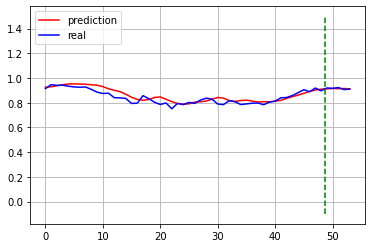

1 day mse: 0.00057
1 day ori mse: 6.56912
1 day ori mae: 1.69476
2 day mse: 0.00088
2 day ori mse: 10.18802
2 day ori mae: 2.11991
3 day mse: 0.00117
3 day ori mse: 13.53413
3 day ori mae: 2.45955


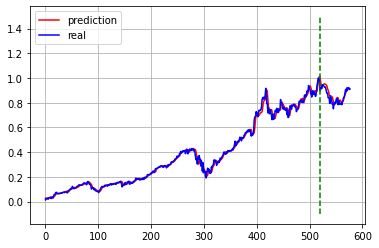

In [23]:
my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')
    

In [10]:
def my_eval(comp, with_sent):
    csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
    train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
    # train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
    trained_model, train_scaler = my_train(train_dataset)

    my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
    ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')
    
    pred_df, tgt_df = data2df(ori_preds, ori_targets, ori_dataset)
#     pred_df.to_csv(f'new/{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)
#     tgt_df.to_csv(f'new/{comp}_tgt{"_sent" if with_sent else ""}.csv', index=False)

In [11]:
def data2df(ori_preds, ori_targets, ori_dataset):
    out_preds = []
    out_tgts = []
    
    print(len(ori_preds), len(ori_targets), len(ori_dataset))
    for i in range(len(ori_preds)):
        out_preds.append(ori_preds[i])
        out_tgts.append(ori_targets[i])

    out_preds_df = pd.DataFrame()
    out_preds_df['Date'] = ori_dataset['Date'][3:-2].values
#     out_preds_df['Date']
    out_preds_df['Close'] = out_preds



    out_tgts_df = pd.DataFrame()
    out_tgts_df['Date'] = ori_dataset['Date'][3:-2].values
    out_tgts_df['Close'] = out_tgts
    
    return out_preds_df, out_tgts_df

1 day mse: 0.00083
1 day ori mse: 9.66551
1 day ori mae: 2.39870
2 day mse: 0.00148
2 day ori mse: 17.13831
2 day ori mae: 3.22517
3 day mse: 0.00205
3 day ori mse: 23.78458
3 day ori mae: 3.78113


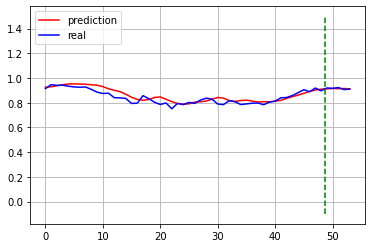

1 day mse: 0.00057
1 day ori mse: 6.56912
1 day ori mae: 1.69476
2 day mse: 0.00088
2 day ori mse: 10.18802
2 day ori mae: 2.11991
3 day mse: 0.00117
3 day ori mse: 13.53413
3 day ori mae: 2.45955


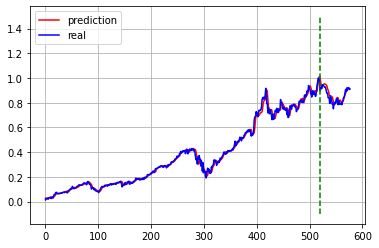

577 577 582


In [49]:
comp = 'aapl'

my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')

pred_df, tgt_df = data2df(ori_preds, ori_targets, ori_dataset)
pred_df.to_csv(f'new/{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)
tgt_df.to_csv(f'new/{comp}_tgt{"_sent" if with_sent else ""}.csv', index=False)

## evaluation

aapl


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00486
Epoch: 200, Loss:0.00310
Epoch: 300, Loss:0.00233
Epoch: 400, Loss:0.00205
Epoch: 500, Loss:0.00165
Epoch: 600, Loss:0.00183
Epoch: 700, Loss:0.00136
1 day mse: 0.00151
1 day ori mse: 17.47745
1 day ori mae: 3.32310
2 day mse: 0.00286
2 day ori mse: 33.12655
2 day ori mae: 4.54961
3 day mse: 0.00409
3 day ori mse: 47.33025
3 day ori mae: 5.37688


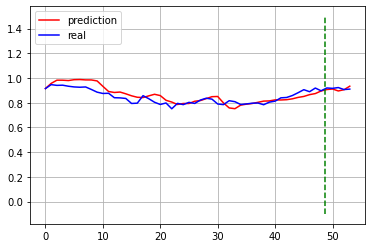

1 day mse: 0.00057
1 day ori mse: 6.61291
1 day ori mae: 1.75405
2 day mse: 0.00089
2 day ori mse: 10.29858
2 day ori mae: 2.15308
3 day mse: 0.00121
3 day ori mse: 14.06000
3 day ori mae: 2.51107


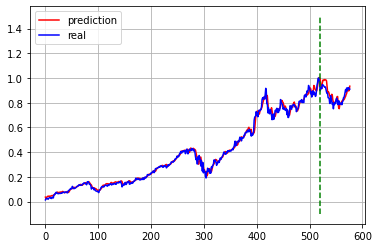

577 577 582
amzn


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00229
Epoch: 200, Loss:0.00238
Epoch: 300, Loss:0.00230
Epoch: 400, Loss:0.00219
Epoch: 500, Loss:0.00207
Epoch: 600, Loss:0.00199
Epoch: 700, Loss:0.00193
1 day mse: 0.00118
1 day ori mse: 4879.45898
1 day ori mae: 57.93861
2 day mse: 0.00159
2 day ori mse: 6574.52393
2 day ori mae: 68.43196
3 day mse: 0.00205
3 day ori mse: 8461.34863
3 day ori mae: 76.49377


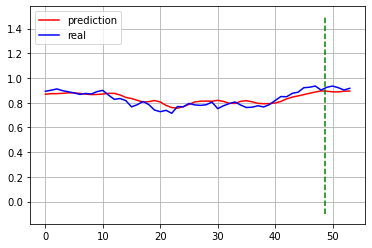

1 day mse: 0.00082
1 day ori mse: 3383.14185
1 day ori mae: 42.30710
2 day mse: 0.00115
2 day ori mse: 4741.90186
2 day ori mae: 50.32604
3 day mse: 0.00147
3 day ori mse: 6057.94189
3 day ori mae: 58.00964


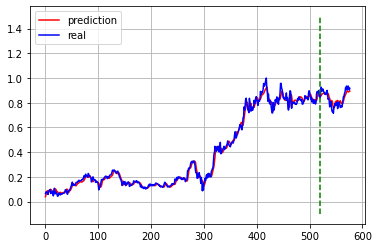

577 577 582
goog


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00615
Epoch: 200, Loss:0.00609
Epoch: 300, Loss:0.00614
Epoch: 400, Loss:0.00604
Epoch: 500, Loss:0.00575
Epoch: 600, Loss:0.00526
Epoch: 700, Loss:0.00462
1 day mse: 0.00193
1 day ori mse: 1569.04675
1 day ori mae: 30.85163
2 day mse: 0.00266
2 day ori mse: 2160.70508
2 day ori mae: 36.73062
3 day mse: 0.00430
3 day ori mse: 3493.81885
3 day ori mae: 44.89460


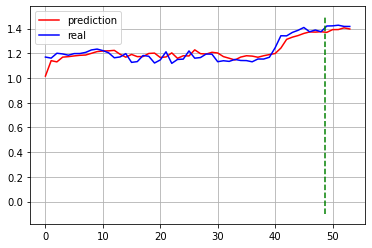

1 day mse: 0.00095
1 day ori mse: 767.51746
1 day ori mae: 19.81484
2 day mse: 0.00152
2 day ori mse: 1235.43091
2 day ori mae: 25.65410
3 day mse: 0.00238
3 day ori mse: 1930.89233
3 day ori mae: 31.84669


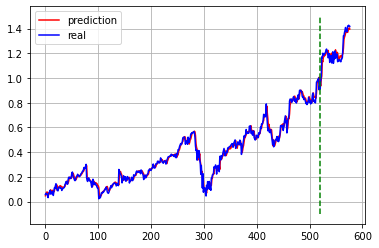

577 577 582
msft


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00519
Epoch: 200, Loss:0.00472
Epoch: 300, Loss:0.00434
Epoch: 400, Loss:0.00391
Epoch: 500, Loss:0.00349
Epoch: 600, Loss:0.00311
Epoch: 700, Loss:0.00304
1 day mse: 0.00169
1 day ori mse: 33.78025
1 day ori mae: 4.96082
2 day mse: 0.00207
2 day ori mse: 41.47503
2 day ori mae: 5.45795
3 day mse: 0.00219
3 day ori mse: 43.86306
3 day ori mae: 5.59858


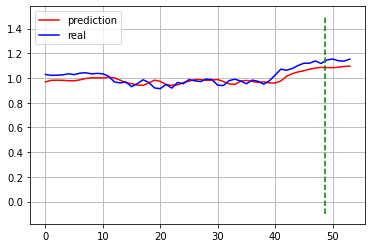

1 day mse: 0.00084
1 day ori mse: 16.77564
1 day ori mae: 3.03370
2 day mse: 0.00111
2 day ori mse: 22.18205
2 day ori mae: 3.50129
3 day mse: 0.00141
3 day ori mse: 28.22367
3 day ori mae: 3.99048


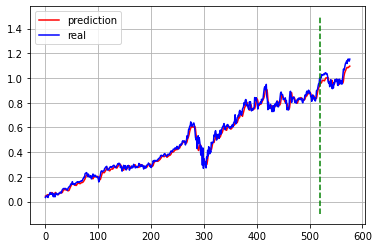

577 577 582
nflx


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.01856
Epoch: 200, Loss:0.01489
Epoch: 300, Loss:0.01221
Epoch: 400, Loss:0.01134
Epoch: 500, Loss:0.01116
Epoch: 600, Loss:0.01095
Epoch: 700, Loss:0.01069
1 day mse: 0.00172
1 day ori mse: 189.82103
1 day ori mae: 10.81371
2 day mse: 0.00273
2 day ori mse: 300.10812
2 day ori mae: 14.81466
3 day mse: 0.00325
3 day ori mse: 357.58340
3 day ori mae: 15.28159


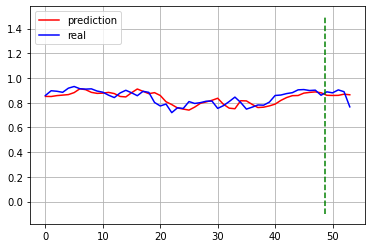

1 day mse: 0.00134
1 day ori mse: 147.12143
1 day ori mae: 8.84248
2 day mse: 0.00206
2 day ori mse: 226.23329
2 day ori mae: 11.32741
3 day mse: 0.00250
3 day ori mse: 275.18387
3 day ori mae: 12.38975


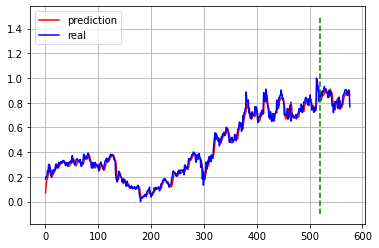

577 577 582
tsla


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00038
Epoch: 200, Loss:0.00226
Epoch: 300, Loss:0.00158
Epoch: 400, Loss:0.00171
Epoch: 500, Loss:0.00161
Epoch: 600, Loss:0.00149
Epoch: 700, Loss:0.00137
1 day mse: 0.00896
1 day ori mse: 6430.17480
1 day ori mae: 69.38657
2 day mse: 0.01136
2 day ori mse: 8152.77441
2 day ori mae: 76.61490
3 day mse: 0.01278
3 day ori mse: 9177.25098
3 day ori mae: 81.01866


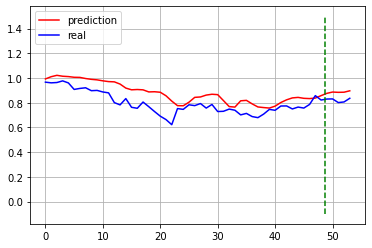

1 day mse: 0.00122
1 day ori mse: 875.90845
1 day ori mae: 16.90270
2 day mse: 0.00162
2 day ori mse: 1160.24902
2 day ori mae: 20.25950
3 day mse: 0.00188
3 day ori mse: 1346.85144
3 day ori mae: 21.76085


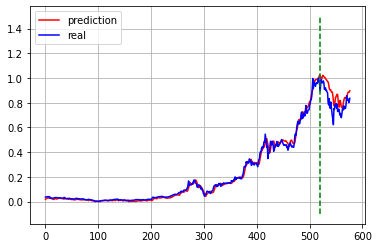

577 577 582


In [12]:
comps = ['aapl', 'amzn', 'goog', 'msft', 'nflx', 'tsla']

for comp in comps:
    print(comp)
    my_eval(comp, with_sent)


## Predict

In [130]:
def pred_test(model, test_dataset, train_scaler):
    model.eval()
    loss_function = nn.MSELoss()
    
    test_dataset = test_dataset.append({'Date': '2021-04-26'}, ignore_index=True)
    test_dataset = test_dataset.append({'Date': '2021-04-27'}, ignore_index=True)
    test_dataset = test_dataset.append({'Date': '2021-04-28'}, ignore_index=True)

#     print(test_dataset)
    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
#     test_data = test_data.iloc
    test_D = DataLoader(dataset=test_data, batch_size=1)

    
    ori_preds = defaultdict(list)
    ori_targets = defaultdict(list)
    
    def rev_scale(x):
        return (x - train_scaler.min_[3]) / train_scaler.scale_[3]

    print(len(test_D), len(test_dataset))
    for i, (test_x, test_y) in enumerate(test_D):
        
#         if i == len(test_D) - 1:
#             print(test_x, test_y)
            
        test_x = test_x.transpose(0, 1)
#         test_x = test_x.to(device)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
#         pred_y = pred_y.cpu()
#         print(pred_y)


        tmp_pred_y = pred_y.detach().numpy()[0]
        tmp_test_y = test_y.detach().numpy()[0]

        for i in range(3):
            
#             preds[str(i)].append(tmp_pred_y[i])
#             targets[str(i)].append(tmp_test_y[i])

            ori_pred_y = (tmp_pred_y[i] - train_scaler.min_[3]) / train_scaler.scale_[3]
            ori_test_y = (tmp_test_y[i] - train_scaler.min_[3]) / train_scaler.scale_[3]


            ori_preds[str(i)].append(ori_pred_y)
            ori_targets[str(i)].append(ori_test_y)
                
#     print(ori_preds, ori_targets)

# ""
#     for i in range(len(ori_preds)):
#         print(ori_preds[i], ori_targets[i])
        
    return ori_preds

In [140]:
def my_predict(comp, with_sent):
    csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
    train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
    # train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
    trained_model, train_scaler = my_train(train_dataset)

    res = pred_test(trained_model, ori_dataset, train_scaler)
    
    output = res['0'] + [res['1'][-1]] + [res['2'][-1]]
#     print(comp, res['0'][-9:], res['1'][-1], res['2'][-1])
    
    def d2f(ori_preds, ori_targets, ori_dataset):
        out_preds = []
#         out_tgts = []

        print(len(ori_preds), len(ori_targets), len(ori_dataset))
        for i in range(len(ori_preds)):
            out_preds.append(ori_preds[i])
#             out_tgts.append(ori_targets[i])

        ori_dataset = ori_dataset.append({'Date': '2021-04-26'}, ignore_index=True)
        ori_dataset = ori_dataset.append({'Date': '2021-04-27'}, ignore_index=True)
        ori_dataset = ori_dataset.append({'Date': '2021-04-28'}, ignore_index=True)
        
        out_preds_df = pd.DataFrame()
        out_preds_df['Date'] = ori_dataset['Date'][3:].values
    #     out_preds_df['Date']
        out_preds_df['Close'] = out_preds



        return out_preds_df
    
#     my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
#     ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')
    
    pred_df = d2f(output, ori_targets, ori_dataset)
    pred_df.to_csv(f'new/{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)
#     tgt_df.to_csv(f'new/{comp}_tgt{"_sent" if with_sent else ""}.csv', index=False)

In [139]:
res = pred_test(trained_model, ori_dataset, train_scaler)
    
output = res['0'] + [res['1'][-1]] + [res['2'][-1]]
#     print(comp, res['0'][-9:], res['1'][-1], res['2'][-1])

def d2f(ori_preds, ori_targets, ori_dataset):
    out_preds = []
#         out_tgts = []

    print(len(ori_preds), len(ori_targets), len(ori_dataset))
    for i in range(len(ori_preds)):
        out_preds.append(ori_preds[i])
#             out_tgts.append(ori_targets[i])

    ori_dataset = ori_dataset.append({'Date': '2021-04-26'}, ignore_index=True)
    ori_dataset = ori_dataset.append({'Date': '2021-04-27'}, ignore_index=True)
    ori_dataset = ori_dataset.append({'Date': '2021-04-28'}, ignore_index=True)

    out_preds_df = pd.DataFrame()
    out_preds_df['Date'] = ori_dataset['Date'][3:].values
#     out_preds_df['Date']
    out_preds_df['Close'] = out_preds

    print(out_preds_df)


    return out_preds_df

#     my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
#     ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')

pred_df = d2f(output, ori_targets, ori_dataset)
pred_df.to_csv(f'new/{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)

580 585
582 577 582
           Date       Close
0    2019-01-07   39.547813
1    2019-01-08   38.638142
2    2019-01-09   39.065575
3    2019-01-10   39.373646
4    2019-01-11   39.694714
..          ...         ...
577  2021-04-22  132.494476
578  2021-04-23  131.830902
579  2021-04-26  132.034958
580  2021-04-27  133.366013
581  2021-04-28  133.601807

[582 rows x 2 columns]


In [141]:
comps = ['aapl', 'amzn', 'goog', 'msft', 'nflx', 'tsla']

for comp in comps:
    print(comp)
    my_predict(comp, with_sent)

aapl


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00765
Epoch: 200, Loss:0.00534
Epoch: 300, Loss:0.00352
Epoch: 400, Loss:0.00271
Epoch: 500, Loss:0.00245
Epoch: 600, Loss:0.00228
Epoch: 700, Loss:0.00201
580 585
582 577 582
amzn


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00214
Epoch: 200, Loss:0.00195
Epoch: 300, Loss:0.00179
Epoch: 400, Loss:0.00168
Epoch: 500, Loss:0.00157
Epoch: 600, Loss:0.00142
Epoch: 700, Loss:0.00205
580 585
582 577 582
goog


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00627
Epoch: 200, Loss:0.00516
Epoch: 300, Loss:0.00486
Epoch: 400, Loss:0.00472
Epoch: 500, Loss:0.00428
Epoch: 600, Loss:0.00314
Epoch: 700, Loss:0.00298
580 585
582 577 582
msft


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00495
Epoch: 200, Loss:0.00385
Epoch: 300, Loss:0.00328
Epoch: 400, Loss:0.00277
Epoch: 500, Loss:0.00232
Epoch: 600, Loss:0.00348
Epoch: 700, Loss:0.00211
580 585
582 577 582
nflx


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.01902
Epoch: 200, Loss:0.01663
Epoch: 300, Loss:0.01502
Epoch: 400, Loss:0.01429
Epoch: 500, Loss:0.01368
Epoch: 600, Loss:0.01314
Epoch: 700, Loss:0.01270
580 585
582 577 582
tsla


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00081
Epoch: 200, Loss:0.00181
Epoch: 300, Loss:0.00195
Epoch: 400, Loss:0.00173
Epoch: 500, Loss:0.00192
Epoch: 600, Loss:0.00136
Epoch: 700, Loss:0.00132
580 585
582 577 582


In [143]:
comps = ['amzn', 'msft']

for comp in comps:
    print(comp)
    my_predict(comp, with_sent)

amzn


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00260
Epoch: 200, Loss:0.00221
Epoch: 300, Loss:0.00156
Epoch: 400, Loss:0.00141
Epoch: 500, Loss:0.00134
Epoch: 600, Loss:0.00131
Epoch: 700, Loss:0.00113
580 585
582 577 582
msft


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00420
Epoch: 200, Loss:0.00246
Epoch: 300, Loss:0.00186
Epoch: 400, Loss:0.00130
Epoch: 500, Loss:0.00116
Epoch: 600, Loss:0.00133
Epoch: 700, Loss:0.00060
580 585
582 577 582


## try xgboost to select features

In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

TEST_SIZE = 0.3

def xgb_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(ori_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


train_data, test_data, ori_data = xgb_load_data('data/AAPL.csv')

train_data = train_data.iloc[:, 1:]
train_x = train_data.iloc[:-1, 1:]
train_y = train_data.iloc[1:, 4].values

test_data = test_data.iloc[:, 1:]
test_x = test_data.iloc[:-1, 1:]
test_y = test_data.iloc[1:, 4].values

/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [20]:
data_dmatrix = xgb.DMatrix(data=train_x.values,label=train_y)
test_dmatrix = xgb.DMatrix(data=test_x.values,label=test_y)

rses = []
# for i in range(10):
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
            'max_depth': 6, 'alpha': 11, 'tree_method': 'hist', 'lambda': 0.1} 
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50, evals=[(test_dmatrix, 'errors')])
te_preds = xg_reg.predict(test_dmatrix)
rmse = np.sqrt(mean_squared_error(test_y, te_preds))
print('rmse: ', rmse)
#     rses.append((pt, rmse))
#     print(i, rmse)

[20:32:52] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	errors-rmse:113.01026
[1]	errors-rmse:104.49601
[2]	errors-rmse:96.74514
[3]	errors-rmse:89.93866
[4]	errors-rmse:83.43624
[5]	errors-rmse:77.58589
[6]	errors-rmse:72.59512
[7]	errors-rmse:66.93047
[8]	errors-rmse:61.83071
[9]	errors-rmse:57.24035
[10]	errors-rmse:53.82044
[11]	errors-rmse:50.03221
[12]	errors-rmse:47.02351
[13]	errors-rmse:44.61453
[14]	errors-rmse:41.83351
[15]	errors-rmse:39.64758
[16]	errors-rmse:37.89893
[17]	errors-rmse:35.71607
[18]	errors-rmse:34.17898
[19]	errors-rmse:32.62237
[20]	errors-rmse:31.00129
[21]	errors-rmse:29.75846
[22]	errors-rmse:28.84347
[23]	errors-rmse:27.81024
[24]	errors-rmse:27.08557
[25]	errors-rmse:26.03073
[26]	errors-rmse:25.52164
[27]	errors-rmse:24.98928
[28]	errors-rmse:24.14652
[29]	errors-rmse:24.00672
[30]	errors-rmse:23.32227
[31]	errors-rmse:22.83166
[32]	errors-rmse:22.27708
[

In [26]:
importances = xg_reg.get_score(importance_type='gain')
res = sorted(importances.items(), key=lambda x: -x[1])
res

[('f56', 11905.57040405),
 ('f25', 11737.658460617075),
 ('f0', 8419.552833158667),
 ('f41', 4560.65625),
 ('f3', 3942.2264994197094),
 ('f18', 3173.453125),
 ('f1', 2523.9542467499996),
 ('f31', 1680.225341797),
 ('f32', 1677.2402850985),
 ('f24', 1247.86335563),
 ('f14', 1213.2620371102),
 ('f16', 767.6363924000001),
 ('f13', 728.6583794213999),
 ('f23', 661.4594890025716),
 ('f2', 556.6516581407724),
 ('f66', 307.598145),
 ('f5', 243.39853353891664),
 ('f87', 205.029135086),
 ('f42', 180.27246095),
 ('f57', 76.9911499),
 ('f17', 64.1914062),
 ('f59', 39.22134396166667),
 ('f35', 30.613647484999998),
 ('f65', 24.076538096666667),
 ('f27', 14.2793665),
 ('f51', 12.856872535),
 ('f44', 11.252526250499999),
 ('f30', 9.0066628385),
 ('f43', 6.817631416299999),
 ('f50', 6.76679612),
 ('f8', 6.74428557735),
 ('f78', 6.68048096),
 ('f7', 6.196217864666667),
 ('f69', 5.377791885375),
 ('f46', 5.205932623333333),
 ('f63', 5.142871976),
 ('f74', 4.659321122000001),
 ('f19', 4.3507461549999995)

In [30]:
features = [int(item[0][1:])+1 for item in res[:25]]
print(features)

[57, 26, 1, 42, 4, 19, 2, 32, 33, 25, 15, 17, 14, 24, 3, 67, 6, 88, 43, 58, 18, 60, 36, 66, 28]
